In [1]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (606 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 134443 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The 

EasyProcessError: ignored

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

bash: ../xvfb: No such file or directory
env: DISPLAY=:1


In [2]:
import gym
env = gym.make("CartPole-v0")

import torch
import torch.nn as n
import torch.optim as op
import torch.nn.functional as f

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
env.observation_space.high

array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)

In [4]:
env.observation_space.low

array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32)

In [5]:
env.action_space.n

2

In [6]:
env.observation_space.shape

(4,)

In [0]:
hiddensize=128
batchsize=32
percent=70
from collections import namedtuple

In [0]:
class net(n.Module):
  def __init__(self,indim,hiddensize,actionsize):
    super().__init__()
    self.fc1=n.Linear(4,hiddensize)
    self.fc2=n.Linear(hiddensize,actionsize)

  def forward(self,x):
    out=f.relu(self.fc1(x))
    out=self.fc2(out)
    return out



In [0]:
model1=net(4,128,2)

In [10]:
model1

net(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [0]:
#named tuple
episode=namedtuple("episode",field_names=['reward','steps'])
episodestep=namedtuple("episodestep",field_names=['observation','action'])

In [0]:
def iterate_batches(env,net,batchsize):
  batch=[]
  episodereward=0.0
  episodesteps=[]
  obs=env.reset()
  sm=n.Softmax(dim=1)
  while True:
    obs=torch.FloatTensor(obs).view(1,-1)
    #print(obs.shape)
    actionprobs=sm(net.forward(obs))
    actionprobs=actionprobs.data.numpy()[0]
    action=np.random.choice(len(actionprobs),p=actionprobs)
    nextobs,reward,isdone,_=env.step(action)
    episodereward+=reward
    episodesteps.append(episodestep(observation=obs,action=action))
    if isdone:
      batch.append(episode(reward=episodereward,steps=episodesteps))
      episodereward=0
      episodesteps=[]
      nextobs=env.reset()
      if len(batch)==batchsize:
        yield batch
        batch=[]
    obs=nextobs


In [0]:
def filterbatches(batch,percentile):
  rewards=list(map(lambda x:x.reward,batch))
  rewards_bound=np.percentile(rewards,percentile)
  rewards_mean=float(np.mean(rewards))

  trainobs=[]
  trainact=[]
  for example in batch:
    if example.reward<rewards_bound:
      continue
    #print(example)
    #print(list(map(lambda x:x.observation,example.steps)))
    trainobs.extend(map(lambda x:x.observation,example.steps))
    trainact.extend(map(lambda x:x.action,example.steps))
  
  # print(trainobs[0].shape)
  # print(trainact)
  trainobs=torch.cat(trainobs,axis=0)
  # print(trainobs.shape)
  trainact=torch.LongTensor(trainact)
  return trainobs,trainact,rewards_bound,rewards_mean

In [14]:
env=gym.make("CartPole-v0")

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
model1=net(4,128,2)

In [0]:
import torch.optim as op

In [0]:
loss=n.CrossEntropyLoss()
optim=op.Adam(model1.parameters(),lr=0.001)

In [25]:
count=0
trainloss=[]
trainrew=[]
for i,batch in enumerate(iterate_batches(env,model1,32)):
  obsv,actv,rewb,rewm=filterbatches(batch,70)
  optim.zero_grad()
  #print(obsv.shape)
  actionscores=model1(obsv)
  loss1=loss(actionscores,actv)
  loss1.backward()
  optim.step()
  if count==200:
    break
  if count%20==0:
    print(rewm)
  trainrew.append(rewm)
  
  print(loss1.item())
  trainloss.append(loss1.item())
  count+=1

20.09375
0.7053145170211792
0.6952887773513794
0.69708651304245
0.6932874321937561
0.7010416984558105
0.6969593167304993
0.6863564252853394
0.6953634023666382
0.6902880072593689
0.6903993487358093
0.6925050020217896
0.6831102967262268
0.6837946176528931
0.6798494458198547
0.6815687417984009
0.6785727739334106
0.6836498975753784
0.679235577583313
0.6745783090591431
0.6774551272392273
31.90625
0.6772982478141785
0.6724597811698914
0.6790080070495605
0.6656894087791443
0.6673390865325928
0.660250186920166
0.6678304672241211
0.6559325456619263
0.6644954085350037
0.6563671827316284
0.6745412349700928
0.6621286869049072
0.654480516910553
0.6589086651802063
0.6506784558296204
0.6507044434547424
0.6505603790283203
0.6533043384552002
0.65505450963974
0.6468669772148132
44.03125
0.6544153690338135
0.6432048082351685
0.645086944103241
0.6476896405220032
0.6492089629173279
0.6412388682365417
0.6434876322746277
0.6435195207595825
0.6482123732566833
0.6511869430541992
0.6472002267837524
0.6434790492

In [26]:
trainloss[0]

0.7053145170211792

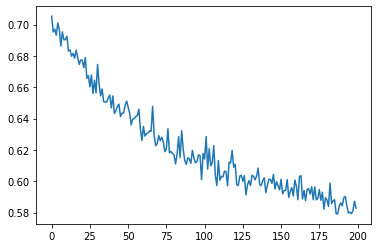

In [27]:
plt.plot(trainloss)

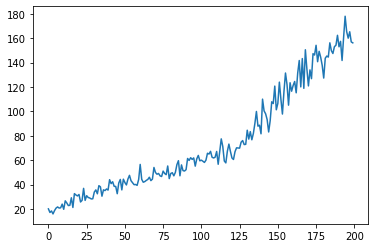

In [29]:
plt.plot(trainrew)